In [1]:
%reload_kedro

2023-06-15 11:38:07,243 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-06-15 11:38:07,944 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-06-15 11:38:08,225 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-06-15 11:38:08,226 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2023-06-15 11:38:08,236 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

### Label balancing

In [4]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
df_mt = catalog.load("master_table_multic")

spine_params = catalog.load("params:spine_labeling")
mt_cls_bds_params = catalog.load("params:mt_class_bounds")

2023-06-15 11:38:09,267 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-06-15 11:38:09,445 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-06-15 11:38:09,458 - kedro.io.data_catalog - INFO - Loading data from `master_table_multic` (ParquetDataSet)...
2023-06-15 11:38:09,469 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...
2023-06-15 11:38:09,469 - kedro.io.data_catalog - INFO - Loading data from `params:mt_class_bounds` (MemoryDataSet)...


In [5]:
# test a different tau value to evaluate class balancing
spine_params

{'tau': 0.35}

In [6]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params)

In [7]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.630487
top       0.369513
Name: label, dtype: float64

In [8]:
# check master table balance, it must be 50/50%
df_mt.label.value_counts() / df_mt.shape[0]

bottom    0.5
top       0.5
Name: label, dtype: float64

### Cumulative volume bars distribution

In [10]:
df_spine_preproc.volume_cumsum.describe()

count     2899.000000
mean     48822.962092
std       1862.133351
min      24114.529130
25%      48600.480110
50%      49451.930001
75%      49796.818308
max      49999.861806
Name: volume_cumsum, dtype: float64

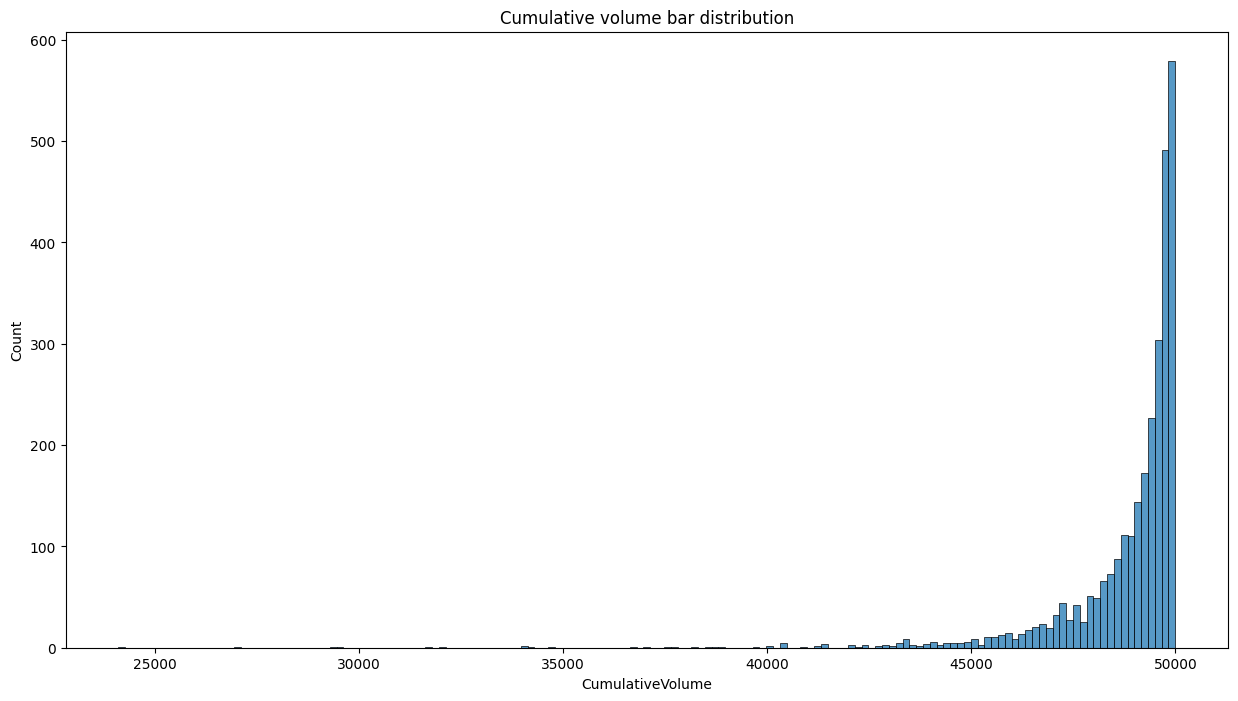

In [18]:
plt.figure(figsize=(15,8))

df = df_spine_preproc[["close_time", "volume_cumsum"]] \
            .rename(columns={"close_time": "Date",
                            "volume_cumsum": "CumulativeVolume"}) \
            .set_index("Date") \
            .sort_index()

plot = sns.histplot(data=df,
             legend=None,
             x="CumulativeVolume"
            ) \
            .set(title="Cumulative volume bar distribution")

# plt.savefig("/Users/gpalazzo/Desktop/fig_volumeBars_distribution.png")

### Volume bar time interval plots

In [ ]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

In [ ]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_duration_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_duration_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_duration_min"] = df_spine_aux["open_close_duration_sec"] / 60.0
df_spine_aux.loc[:, "close_target_duration_min"] = df_spine_aux["close_target_duration_sec"] / 60.0

In [ ]:
df_spine_aux.head()

In [ ]:
df_plot = df_spine_aux[["close_time", "open_close_duration_min", "close_target_duration_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))
plot = sns.boxplot(data=df_plot)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_boxplot_time_windows.png")

In [ ]:
df_plot.describe()